In [29]:
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import pandas as pd
import psycopg2
import calendar

In [30]:
'''conn = psycopg2.connect(
  port='5432',
  host= "shopify-merchant-dump.ccm9mnr5avgs.ap-south-1.rds.amazonaws.com",
  user= "softtouchlenses_4e0b7c925f8444429457581f35678aea",
  password="softtouchlenses_4e0b7c925f8444429457581f35678aea_password",
  database= "softtouchlenses_4e0b7c925f8444429457581f35678aea_db")
conn = psycopg2.connect(
  host='shopify-merchant-dump.ccm9mnr5avgs.ap-south-1.rds.amazonaws.com',
  port='5432',
  user='paakhi_b014108f50994e35ab8fa4e2dc26d612',
  password='paakhi_b014108f50994e35ab8fa4e2dc26d612_password',
  database='paakhi_b014108f50994e35ab8fa4e2dc26d612_db')'''
conn = psycopg2.connect(
    host='shopify-merchant-dump.ccm9mnr5avgs.ap-south-1.rds.amazonaws.com',
    port='5432',
    user='toffee_coffee_roasters_69e3f806d0674953afe3d3fb2f724c7c',
    password='toffee_coffee_roasters_69e3f806d0674953afe3d3fb2f724c7c_password',
    database='toffee_coffee_roasters_69e3f806d0674953afe3d3fb2f724c7c_db'
)

In [31]:
query1 = """select orders.id as order_id,
created_at::date as order_date,
customer_id as user_id,
order_line_item.product_id as product_id,
order_line_item.name as product_name,
order_line_item.quantity as quantity,
(order_line_item.price - order_line_item.total_discount) as sp
from orders
join order_line_item on orders.id  = order_line_item.order_id
where cancelled_at is NULL;"""

In [32]:
data = pd.read_sql(query1, conn)

<ipython-input-32-0600e2216395>:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data = pd.read_sql(query1, conn)


In [33]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93079 entries, 0 to 93078
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   order_id      93079 non-null  int64  
 1   order_date    93079 non-null  object 
 2   user_id       83446 non-null  float64
 3   product_id    92966 non-null  float64
 4   product_name  93079 non-null  object 
 5   quantity      93079 non-null  int64  
 6   sp            93079 non-null  float64
dtypes: float64(3), int64(2), object(2)
memory usage: 5.0+ MB


In [34]:
data.order_date

0        2023-12-08
1        2023-12-08
2        2023-12-08
3        2023-12-08
4        2023-12-08
            ...    
93074    2020-09-12
93075    2020-09-12
93076    2020-09-12
93077    2020-09-12
93078    2020-09-12
Name: order_date, Length: 93079, dtype: object

In [35]:
data

,order_id,order_date,user_id,product_id,product_name,quantity,sp
0,5341764845706,2023-12-08,6.377996e+12,5.321602e+12,South Indian Traditional Filter Coffee - Dark ...,1,299.0
1,5341763338378,2023-12-08,6.935222e+12,5.321602e+12,South Indian Traditional Filter Coffee - Dark ...,1,199.0
2,5341763010698,2023-12-08,6.935222e+12,5.405527e+12,Medium Roast - Coffee Sample Pack - French Press,1,450.0
3,5341763010698,2023-12-08,6.935222e+12,6.624082e+12,Blueberry Mocha - Speciality Blend - 250 gm / ...,1,630.0
4,5341750689930,2023-12-08,6.704616e+12,5.321602e+12,South Indian Traditional Filter Coffee - Dark ...,2,299.0
...,...,...,...,...,...,...,...
93074,2418214437002,2020-09-12,3.554806e+12,5.321692e+12,Cabernet Sauvignon - Wine Barrel Aged Coffee -...,1,1699.0
93075,2418155159690,2020-09-12,3.554806e+12,5.321692e+12,Cabernet Sauvignon - Wine Barrel Aged Coffee -...,1,1699.0
93076,2418154733706,2020-09-12,3.554806e+12,5.321692e+12,Cabernet Sauvignon - Wine Barrel Aged Coffee -...,1,1699.0
93077,2418151194762,2020-09-12,3.554806e+12,5.321692e+12,Cabernet Sauvignon - Wine Barrel Aged Coffee -...,1,1699.0


In [36]:
#New/Repeat Tag
orderuserlevel=data.groupby(['order_id','user_id']).agg(
          order_date=pd.NamedAgg(column='order_date', aggfunc='min'),

    ).reset_index()
orderuserlevel=orderuserlevel.sort_values('order_date')
orderuserlevel['TrxnRank'] = orderuserlevel.groupby('user_id')['order_date'].rank(method='first')
orderuserlevel


data=pd.merge(data,
         orderuserlevel[['order_id','TrxnRank']],
         on="order_id",
         how ='left')
data['New']=0
data['Repeat']=0
data.loc[data['TrxnRank']==1,'New']=1
data.loc[data['TrxnRank']>1,'Repeat']=1

#AOV Contribution
data['ordervalue']=data['quantity']*data['sp']
data['AOVContribution']=data['ordervalue']/data["order_id"].nunique()

In [37]:
totalcarts=data['order_id'].nunique()
productlevel=data.groupby(['product_id','product_name']).agg(
          Carts=pd.NamedAgg(column='order_id', aggfunc='nunique'),
     Quantity=pd.NamedAgg(column='quantity', aggfunc='sum'),
          ASP=pd.NamedAgg(column='sp', aggfunc='mean'),
          NewOrders=pd.NamedAgg(column='New', aggfunc='sum'),
          RepeatOrders=pd.NamedAgg(column='Repeat', aggfunc='sum'),
          Users=pd.NamedAgg(column='user_id', aggfunc='nunique'),
          AOVContribution=pd.NamedAgg(column='AOVContribution', aggfunc='sum'),
    ).reset_index()
productlevel['CartPenetration']=productlevel['Carts']/totalcarts
productlevel['NewUserRatio']=productlevel['NewOrders']/productlevel['Users']
productlevel['QpC']=productlevel['Quantity']/productlevel['Carts']
productlevel['ASPXQpC']=productlevel['ASP']*productlevel['QpC']

In [38]:
productlevel.sort_values('CartPenetration', ascending=False).head(50)

,product_id,product_name,Carts,Quantity,ASP,NewOrders,RepeatOrders,Users,AOVContribution,CartPenetration,NewUserRatio,QpC,ASPXQpC
172,5.321602e+12,South Indian Traditional Filter Coffee - Dark ...,11316,12270,273.626772,10272,1225,10511,48.212348,0.159398,0.977262,1.084305,296.694989
174,5.321602e+12,South Indian Traditional Filter Coffee - Dark ...,8699,8981,304.589261,6807,1909,7605,38.770439,0.122535,0.895069,1.032418,314.463289
800,6.747180e+12,Hazelnut Cold Brew - Easy Brew Cold Brew Bags ...,2019,2175,637.269767,276,172,278,19.516706,0.028440,0.992806,1.077266,686.509036
261,5.321648e+12,Single Malt Whiskey Barrel Aged Coffee - Frenc...,1929,2163,1202.008543,1480,483,1708,36.480026,0.027172,0.866511,1.121306,1347.819843
802,6.747180e+12,Hazelnut Cold Brew - Easy Brew Cold Brew Bags ...,1813,1920,489.368646,1634,235,1736,13.235576,0.025538,0.941244,1.059018,518.250304
100,5.320286e+12,Baba Budangiri Estate Coffee - French Press / ...,1812,1937,542.336198,851,531,1147,14.804767,0.025524,0.741935,1.068985,579.749015
724,6.612165e+12,Easy Brew (Hot Brew) - Whiskey Barrel Aged Cof...,1668,1950,938.631940,1346,353,1481,25.802062,0.023496,0.908845,1.169065,1097.321513
312,5.321724e+12,Easy Brew - Cold Brew Bags (Pack of 4),1486,1537,638.881491,1179,297,1262,13.816064,0.020932,0.934231,1.034320,660.808110
759,6.624082e+12,Blueberry Mocha - Speciality Blend - 250 gm / ...,1227,1277,608.484262,556,460,882,10.937880,0.017284,0.630385,1.040750,633.279871
323,5.321724e+12,Blonde Caramel - Speciality Blend - Cold Brew ...,1145,1190,625.575496,451,308,678,10.494225,0.016129,0.665192,1.039301,650.161433


In [39]:
productlevel = productlevel[productlevel['NewOrders'] != 0]

In [40]:
CP_labels, NewRatio_labels,ASP_labels, QpC_labels =  range(1,5), range(1,5),range(1,5),range(1,5)
#productlevel.fillna(0.0, inplace=True)
productlevel['CP_score'] = productlevel['CartPenetration'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = CP_labels)).astype('int64')
productlevel['NewRatio_score'] = productlevel['NewUserRatio'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = NewRatio_labels)).astype('int64')
productlevel['ASP_score'] = productlevel['ASP'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = ASP_labels)).astype('int64')
productlevel['QpC_score'] = productlevel['QpC'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = QpC_labels)).astype('int64')
productlevel['SumScore'] = productlevel['CP_score'] + productlevel['NewRatio_score'] + productlevel['ASP_score'] + productlevel['QpC_score']


<ipython-input-40-ec247d67d37b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  productlevel['CP_score'] = productlevel['CartPenetration'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = CP_labels)).astype('int64')
<ipython-input-40-ec247d67d37b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  productlevel['NewRatio_score'] = productlevel['NewUserRatio'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = NewRatio_labels)).ast

In [41]:
def ProductCohortLables(df):
    if df['SumScore'] > 15:
        return 'Hero Products'
    elif ((df['CP_score'] >3) and (df['SumScore'] >= 8)and (df['SumScore'] <= 15) and (df['NewRatio_score'] >3)):
        return 'Marquee & New Business Drivers'
    elif ((df['CP_score'] >3) and (df['SumScore'] >= 8)and (df['SumScore'] <= 15)and (df['NewRatio_score'] <=3)):
        return 'Marquee & Repeat Business Drivers'

    elif ((df['ASP_score'] >3) and (df['SumScore'] >= 5)and (df['SumScore'] < 8)and (df['QpC_score'] <=3)):
        return 'High Value & Slow Moving'
    elif ((df['ASP_score'] <=3) and (df['SumScore'] >= 5)and (df['SumScore'] < 8)and (df['QpC_score'] >3)):
        return 'Low Value & Slow Moving'
    else:
        return 'Lagging Products'

In [42]:
productlevel['Product Cohort Lables'] = productlevel.apply(ProductCohortLables, axis=1)


<ipython-input-42-9e88f76a102a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  productlevel['Product Cohort Lables'] = productlevel.apply(ProductCohortLables, axis=1)


In [43]:
productlevel['Product Cohort Lables'].value_counts()

Lagging Products                     602
Marquee & Repeat Business Drivers    203
High Value & Slow Moving               8
Low Value & Slow Moving                1
Name: Product Cohort Lables, dtype: int64

In [44]:
productlevel

,product_id,product_name,Carts,Quantity,ASP,NewOrders,RepeatOrders,Users,AOVContribution,CartPenetration,NewUserRatio,QpC,ASPXQpC,CP_score,NewRatio_score,ASP_score,QpC_score,SumScore,Product Cohort Lables
0,5.320060e+12,Thogarihunkal Estate Coffee - Aeropress / 250 gm,27,27,566.148148,17,10,27,0.215320,0.000380,0.629630,1.000000,566.148148,3,2,1,1,7,Lagging Products
2,5.320060e+12,Thogarihunkal Estate Coffee - Cold Brew / 250 gm,20,21,574.190476,7,3,8,0.169850,0.000282,0.875000,1.050000,602.900000,3,3,1,3,10,Lagging Products
4,5.320060e+12,Thogarihunkal Estate Coffee - Decoction Coffee...,22,23,580.000000,14,8,21,0.187979,0.000310,0.666667,1.045455,606.363636,3,2,1,3,9,Lagging Products
5,5.320060e+12,Thogarihunkal Estate Coffee - Decoction Coffee...,1,1,1170.000000,1,0,1,0.016481,0.000014,1.000000,1.000000,1170.000000,1,3,3,1,8,Lagging Products
6,5.320060e+12,Thogarihunkal Estate Coffee - Espresso / 1000 gm,1,1,2340.000000,1,0,1,0.032961,0.000014,1.000000,1.000000,2340.000000,1,3,4,1,9,Lagging Products
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
907,7.742866e+12,South Indian Traditional Filter Coffee - Dark ...,20,24,770.000000,15,5,19,0.260311,0.000282,0.789474,1.200000,924.000000,3,3,2,4,12,Lagging Products
908,7.792635e+12,Brazil & Ethiopia Speciality Instant Coffee (P...,7,8,548.000000,4,3,6,0.065275,0.000099,0.666667,1.142857,626.285714,2,2,1,4,9,Lagging Products
910,7.792637e+12,Colombia & Ethiopia Speciality Instant Coffee ...,2,2,748.000000,2,0,2,0.021073,0.000028,1.000000,1.000000,748.000000,1,4,2,2,9,Lagging Products
911,7.792641e+12,Brazil & Colombia Speciality Instant Coffee (P...,1,1,698.000000,1,0,1,0.009832,0.000014,1.000000,1.000000,698.000000,1,4,2,2,9,Lagging Products


In [45]:
segstats=productlevel.groupby(
   'Product Cohort Lables'
).agg(
       ProductCount=pd.NamedAgg(column='product_id', aggfunc='nunique'),
       Orders=pd.NamedAgg(column='Carts', aggfunc='sum'),
       Users=pd.NamedAgg(column='Users', aggfunc='sum'),
       AverageSellingPrice=pd.NamedAgg(column='ASP', aggfunc='mean'),
       QuantityperCart=pd.NamedAgg(column='QpC', aggfunc='mean'),
       CartPenetration  =pd.NamedAgg(column='CartPenetration', aggfunc='mean'),
       NewUserRatio=pd.NamedAgg(column='NewUserRatio', aggfunc='mean'),
      NewOrders=pd.NamedAgg(column='NewOrders', aggfunc='sum'),
       ASPXQpC=pd.NamedAgg(column='ASPXQpC', aggfunc='sum'),
       AOVContribution=pd.NamedAgg(column='AOVContribution', aggfunc='sum'),
       Top10SKUs=pd.NamedAgg(column='product_name', aggfunc=lambda x: x.value_counts().index[:10]),
      Bottom10SKUs=pd.NamedAgg(column='product_name', aggfunc=lambda x: x.value_counts().index[-10:-1])

 ).reset_index()
segstats=segstats.sort_values('CartPenetration', ascending =False)
segstats
segstats['ProductCountMix']=segstats['ProductCount']/segstats['ProductCount'].sum()
segstats['OrdersMix']=segstats['Orders']/segstats['Orders'].sum()
segstats['UsersMix']=segstats['Users']/segstats['Users'].sum()
segstats['AOVContribution(%)']=segstats['AOVContribution']/segstats['AOVContribution'].sum()
segstats['OrderPerSKU']=segstats['Orders']/segstats['ProductCount']

In [46]:
segstats.columns

Index(['Product Cohort Lables', 'ProductCount', 'Orders', 'Users',
       'AverageSellingPrice', 'QuantityperCart', 'CartPenetration',
       'NewUserRatio', 'NewOrders', 'ASPXQpC', 'AOVContribution', 'Top10SKUs',
       'Bottom10SKUs', 'ProductCountMix', 'OrdersMix', 'UsersMix',
       'AOVContribution(%)', 'OrderPerSKU'],
      dtype='object')

In [47]:
SummaryTable=segstats[['Product Cohort Lables', 'ProductCount','OrdersMix',
       'UsersMix','AverageSellingPrice',
       'CartPenetration',"QuantityperCart",'NewUserRatio','AOVContribution',
       'Top10SKUs', 'Bottom10SKUs','OrderPerSKU', ]]


In [48]:
SummaryTable.to_csv('st.csv')
#productlevel.to_csv('pl.csv')

In [50]:
SummaryTable


,Product Cohort Lables,ProductCount,OrdersMix,UsersMix,AverageSellingPrice,CartPenetration,QuantityperCart,NewUserRatio,AOVContribution,Top10SKUs,Bottom10SKUs,OrderPerSKU
3,Marquee & Repeat Business Drivers,48,0.927165,0.918465,790.250217,0.005843,1.089541,0.639897,808.221293,[Thogarihunkal Estate Coffee - Espresso / 250 ...,[Single Malt Whiskey Barrel Aged Coffee - Whol...,1754.312500
1,Lagging Products,101,0.072604,0.081275,1440.206087,0.000154,1.080493,0.752104,127.703276,[Thogarihunkal Estate Coffee - Aeropress / 250...,[Original Cold Brew Bags - Easy Brew (Cold Bre...,65.287129
2,Low Value & Slow Moving,1,0.000033,0.000027,585.000000,0.000042,1.333333,0.500000,0.032961,Thogurihunkal Estate Coffee - Aeropress / 250 gm,[],3.000000
0,High Value & Slow Moving,6,0.000198,0.000232,2347.500000,0.000032,1.000000,0.479167,0.600279,[Thippanahalli Estate Coffee - Moka Pot / 1000...,[Thippanahalli Estate Coffee - Moka Pot / 1000...,3.000000


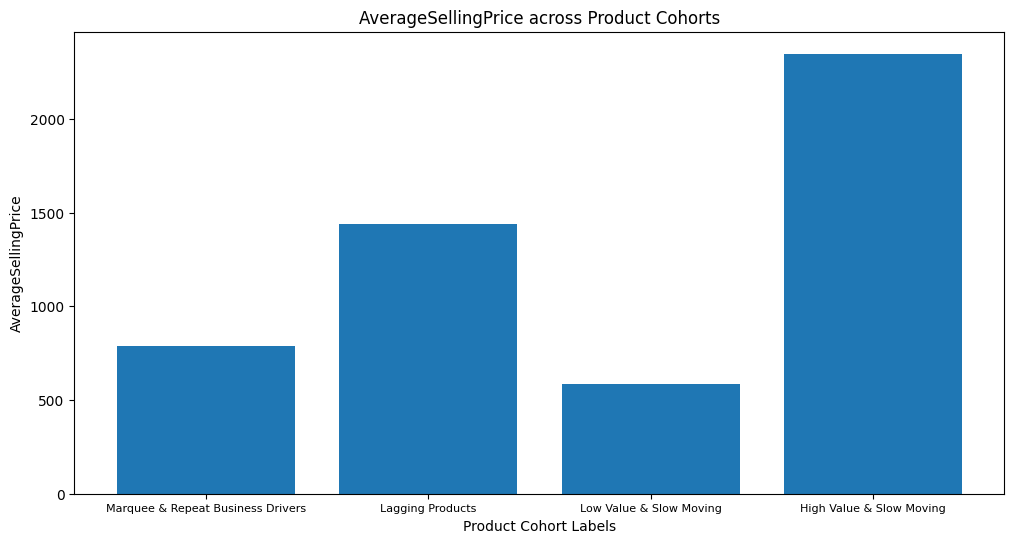

In [51]:
column_to_plot = 'AverageSellingPrice'
x_labels = SummaryTable['Product Cohort Lables']
plt.figure(figsize=(12, 6))  # Adjust the figure size if needed
plt.bar(x_labels, SummaryTable[column_to_plot])
plt.xlabel('Product Cohort Labels')
plt.ylabel(column_to_plot)
plt.title(f'{column_to_plot} across Product Cohorts')
plt.xticks(fontsize=8)
plt.show()

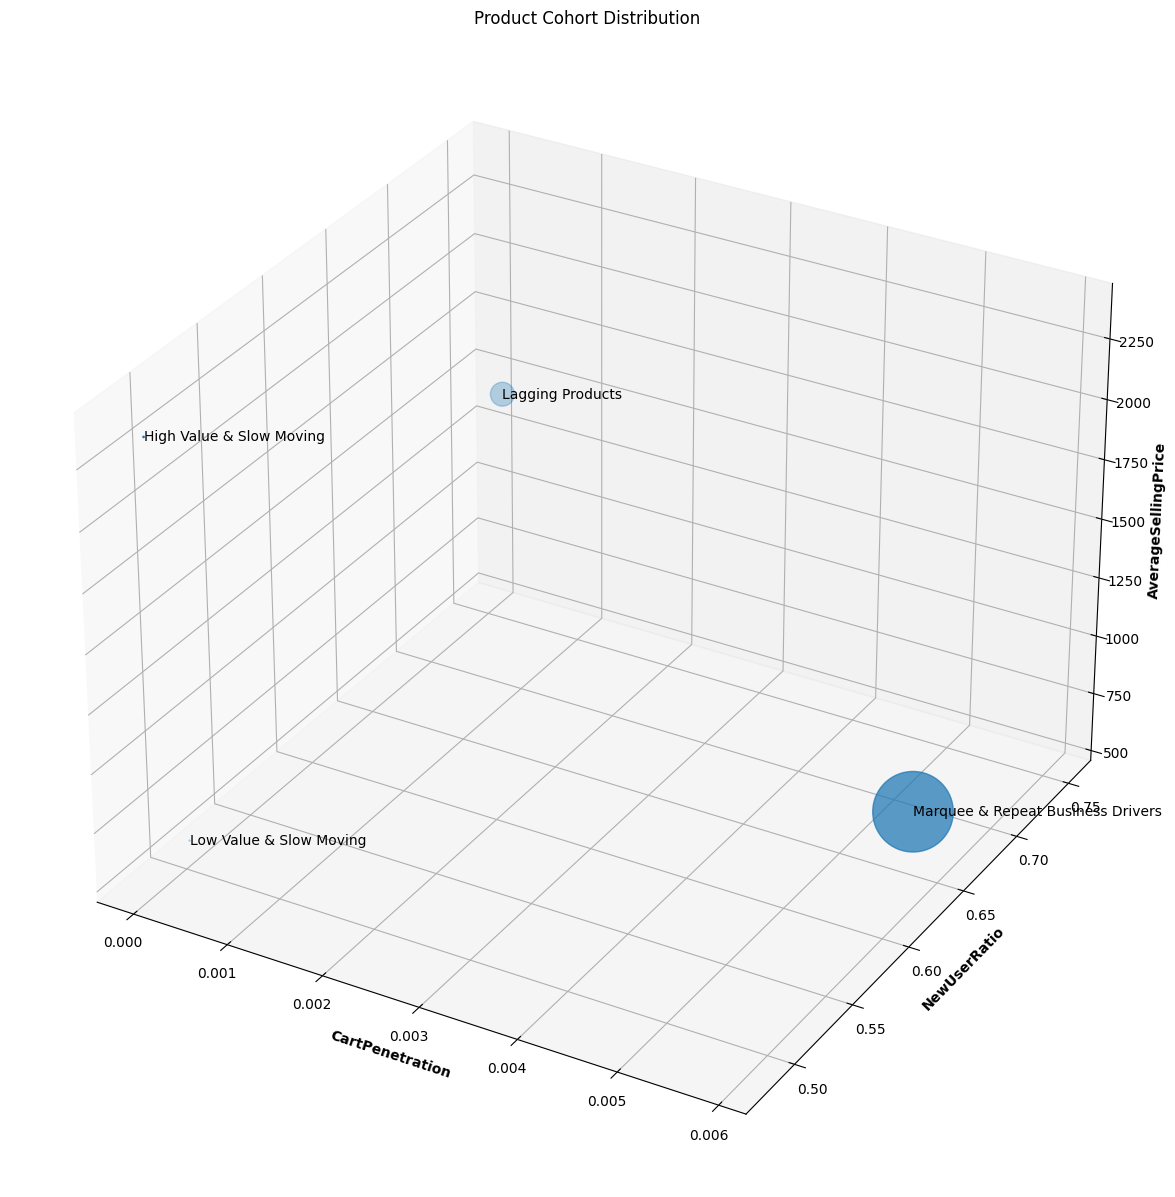

In [52]:
#Visualization of cohorts with key parameters as axises
fig = plt.figure(figsize = (15, 15))
ax = plt.axes(projection ="3d")
size=segstats['Users']*.05
# Creating plot
ax.scatter3D(segstats['CartPenetration'], segstats['NewUserRatio'],segstats['AverageSellingPrice'], s=size)
plt.title("Product Cohort Distribution")
ax.set_xlabel('CartPenetration', fontweight ='bold')
ax.set_ylabel('NewUserRatio', fontweight ='bold')
ax.set_zlabel('AverageSellingPrice', fontweight ='bold')
for i in range(len(segstats)):
     ax.text(segstats['CartPenetration'][i],
               segstats['NewUserRatio'][i],
             segstats['AverageSellingPrice'][i],
               segstats['Product Cohort Lables'][i],
               horizontalalignment='left',
               rotation=25, wrap=True,
               verticalalignment='center',
               size='medium', color='black')
